In [1]:
from scipy import misc
import numpy as np
from scipy.fftpack import dct, idct
from skimage.color import rgb2lab, lab2rgb
import math
import matplotlib.pyplot as plt
from quant_tables import *
%matplotlib inline

In [2]:
calBlue = misc.imread('images/calBlue.tiff')
Marconi = misc.imread('images/Marconi.tiff')
createrLake = misc.imread('images/createrLake.tiff')
Isee = misc.imread('images/Isee.tiff')
pauly = misc.imread('images/pauly.tiff')

In [3]:
def zeropad_image(V):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    rows, cols = roundup(V.shape[0]), roundup(V.shape[1])
    zeros = np.zeros((rows, cols, 3), dtype='uint8')
    zeros[:V.shape[0], :V.shape[1], :] = V
    return zeros

In [39]:
#Zero_pad
O = zeropad_image(calBlue)
#Conver to YCbCr
O = rgb2lab(O)
#Add offset
O[:,:,[1,2]] += 128

In [40]:
def block_image(V):
    l = []
    for i in np.arange(0,V.shape[0], 8):
        for j in np.arange(0, V.shape[1], 8):
            l.append(V[i:i+8, j:j+8, :])
    return np.array(l)

def dct_2d(X):
    return dct(dct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

def dct_all(X):
    blocks = block_image(X)
    return dct_2d(blocks)

def idct_2d(X):
    return idct(idct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

#Blocks and applies DCT
blocked_image = block_image(O)
O_dct = dct_2d(blocked_image)

In [47]:
def quantize(DCT_coeffs, q):
    DCT_coeffs = DCT_coeffs.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    DCT_coeffs[:,:,:,0] = np.round(DCT_coeffs[:,:,:,0]*1.0/(alpha*luminance_table))
    DCT_coeffs[:,:,:,1] = np.round(DCT_coeffs[:,:,:,1]*1.0/(alpha*chrominance_table))
    DCT_coeffs[:,:,:,2] = np.round(DCT_coeffs[:,:,:,2]*1.0/(alpha*chrominance_table))
    
    return DCT_coeffs

O_q = quantize(dct_all(O),50)

In [48]:
def JPEG_compression(image, quality = 50):
    """
    
    Takes in an RGB image and applys the JPEG compression algorithm
    Steps:
    -Preprocessing
    -DCT
    -Quantinization
    
    Input:
    quality- determines the amount of lossy compression 
    
    Output:
    Numpy array of 8x8 blocks for each channel
    [number of blocks, 8,8,3]
    """
    #Prepocessing
    im = zeropad_image(image)
    im = rgb2lab(im)
    im[:,:,[1,2]] += 128
    #Blocked into 8x8 blocks and apply DCT
    im_dct = dct_all(im)
    #Quantize
    im_q = quantize(im_dct,quality)
    return im_q

In [49]:
data = JPEG_compression(calBlue,50)

In [61]:
def idct_2d(X):
    return idct(idct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

def unblock_image(X,height, width):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    height, width = roundup(height), roundup(width)
    result = np.zeros((height,width,3))
    n = 0
    for i in np.arange(0,height, 8):
        for j in np.arange(0, width, 8):
            result[i:i+8,j:j+8,:] = X[n]
            n += 1
    return result
    
def unquantize(X,q):
    X = X.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    X[:,:,:,0] = np.round(X[:,:,:,0]*(alpha*luminance_table))
    X[:,:,:,1] = np.round(X[:,:,:,1]*(alpha*chrominance_table))
    X[:,:,:,2] = np.round(X[:,:,:,2]*(alpha*chrominance_table))
    
    return X


In [62]:
def JPEG_decompression(data,quality,height,width):
    im_q = unquantize(data,quality)
    #IDCT
    im_idct = idct_2d(im_q)
    #Unblock
    im = unblock_image(im_idct,height,width)
    
    #Undo offset and return to RGB
    im[:,:,[1,2]] -= 128
    im = lab2rgb(im)
    return im[0:height,0:width]

In [63]:
data = JPEG_compression(calBlue,50)
im = JPEG_decompression(data,50,calBlue.shape[0],calBlue.shape[1])

NameError: global name 'V' is not defined

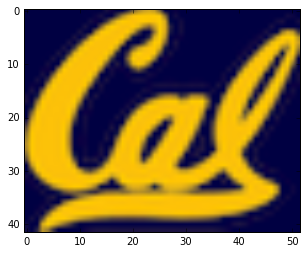

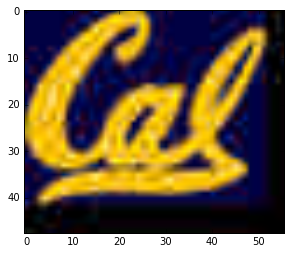

In [58]:
plt.imshow(calBlue);plt.show()
plt.imshow(im)